# Description

Initial EDA for potential propensity score matching leakage.

# Imports

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg

from ipywidgets import interact

%matplotlib inline

# Load data

In [2]:
psm_leak = pd.read_csv("psm_leakage.csv")

# create a unique study id via index
psm_leak = psm_leak.reset_index()
psm_leak = psm_leak.rename({"index": "study_id"}, axis="columns")
psm_leak['study_id'] = psm_leak['study_id'].astype(str)
psm_leak.head()
psm_leak['ci_diff'] = psm_leak['upper_ci'] - psm_leak['lower_ci']

In [3]:
(np.log(psm_leak['ci_diff']) + 1).describe()

count    89.000000
mean      1.027044
std       0.984797
min      -0.897120
25%       0.266031
50%       0.916618
75%       1.631272
max       3.060514
Name: ci_diff, dtype: float64

Text(0.5, 0, 'ps estimates')

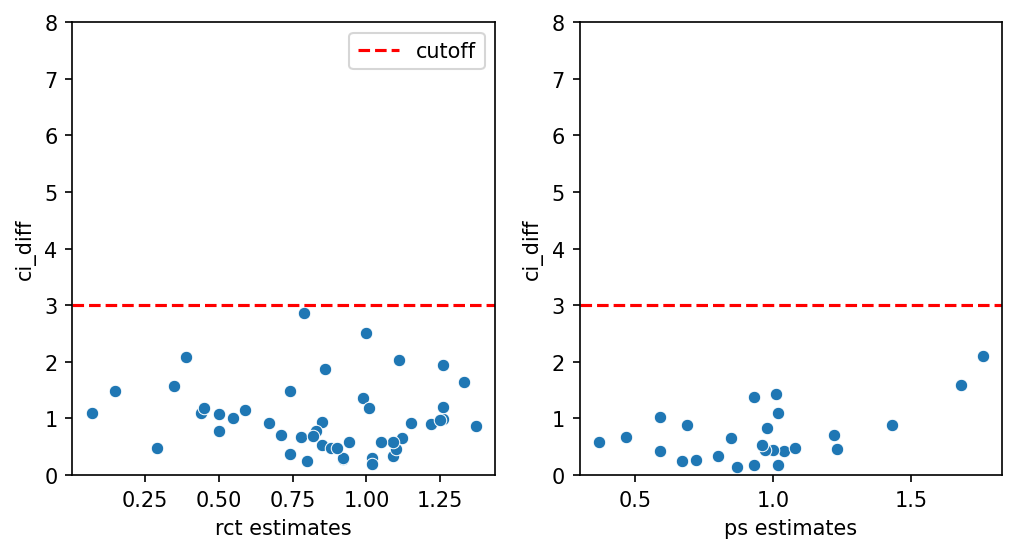

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=150, figsize=(8,4))
rct = psm_leak[psm_leak['study_type'] == 'RCT']
ps = psm_leak[psm_leak['study_type'] == 'PS']

sns.scatterplot(data=rct, x='estimate', y='ci_diff', ax=ax1)
ax1.set_ylim(0, 8)
ax1.set_xlabel("rct estimates")
ax1.axhline(y=3, ls='--', color='red', label='cutoff')
ax1.legend()

sns.scatterplot(data=ps, x='estimate', y='ci_diff', ax=ax2)
ax2.set_ylim(0, 8)
ax2.axhline(y=3, ls='--', color='red', label='cutoff')
ax2.set_xlabel("ps estimates")


In [7]:
rct[rct['ci_diff'] > 3]

,study_id,study_type,year,clinical_setting,estimate,lower_ci,upper_ci,ci_diff
9,9,RCT,1993,hyperoncotic starches vs crystalloids (ICU),0.94,0.20,4.41,4.21
10,10,RCT,1998,hyperoncotic starches vs crystalloids (ICU),0.53,0.07,4.01,3.94
12,12,RCT,2008,hyperoncotic starches vs crystalloids (ICU),0.87,0.22,3.35,3.13
15,15,RCT,2010,hyperoncotic starches vs crystalloids (ICU),0.88,0.10,7.95,7.85
16,16,RCT,2011,hyperoncotic starches vs crystalloids (ICU),2.22,0.77,6.39,5.62
22,22,RCT,1977,hyperoncotic albumin vs crystalloids (ICU),1.50,0.29,7.71,7.42
23,23,RCT,1990,hyperoncotic albumin vs crystalloids (ICU),1.70,0.45,6.44,5.99
24,24,RCT,2004,hyperoncotic albumin vs crystalloids (ICU),1.31,0.26,6.72,6.46
25,25,RCT,2004,hyperoncotic albumin vs crystalloids (ICU),1.00,0.17,5.98,5.81
28,28,RCT,1997,diuretics in AKI (inhospital),2.10,0.86,5.12,4.26


In [9]:
psm_leak['study_type'].value_counts()

RCT    62
PS     27
Name: study_type, dtype: int64

# Clip studies with large CIs

In [9]:
# comment this out if we don't want to clip by such studies
sel_psm_leak = psm_leak[psm_leak['ci_diff'] < 3]

# Compute pairwise differences

For each PS study within a clinical setting, we pair it with an RCT and compute
both the year difference as well as the point estimate difference.

$$
\text{diff}_{norm} = \frac{\text{eff}_{PS} - \text{eff}_{RCT}}{\text{eff}_{PS} + \text{eff}_{RCT}}
$$

We want to make the comparison:

$$
E[\text{diff}_{norm} | \text{PS first}] \text{ vs. } E[\text{diff}_{norm} | \text{PS second}]
$$

In [17]:
pair_df = pd.DataFrame()
for clinic_set, group in sel_psm_leak.groupby("clinical_setting"):
    ps_df = group[group['study_type'] == 'PS']
    rct_df = group[group['study_type'] == 'RCT']
    for idx, ps in ps_df.iterrows():
        ps_dict = {
            "study_id": [],
            "rct_year": [],
            "ps_year": [],
            "year_diff": [],
            "rct_est": [],
            "ps_est": [],
            "clinical_setting": []
        }
        for idx, rct in rct_df.iterrows():
            ps_dict['study_id'].append(ps['study_id'])
            ps_dict['ps_year'].append(ps['year'])
            ps_dict['rct_year'].append(rct['year'])
            ps_dict['year_diff'].append(ps['year'] - rct['year'])
            ps_dict['rct_est'].append(rct['estimate'])
            ps_dict['ps_est'].append(ps['estimate'])
            ps_dict['clinical_setting'].append(ps['clinical_setting'])
        
        df = pd.DataFrame.from_dict(ps_dict)
        pair_df = pair_df.append(df)

In [18]:
pair_df['raw_diff'] = pair_df['ps_est'] - pair_df['rct_est']
pair_df['norm_diff'] = pair_df['raw_diff'] / (pair_df['ps_est'] + pair_df['rct_est'])

In [19]:
pair_df['rct_est'] = np.log(pair_df['rct_est'])
pair_df['ps_est'] = np.log(pair_df['ps_est'])

In [20]:
no_zero_pairs = pair_df[pair_df['year_diff'] != 0]

In [21]:
no_zero_pairs['ps_after'] = (no_zero_pairs['year_diff'] > 0).astype(int)

/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
psm_leak[psm_leak['study_type'] == 'PS'].head(50)

,study_id,study_type,year,clinical_setting,estimate,lower_ci,upper_ci,ci_diff
5,5,PS,2008,APC in sepsis (inhospital),0.72,0.60,0.86,0.26
6,6,PS,2008,APC in sepsis (inhospital),0.59,0.41,0.84,0.43
7,7,PS,2008,APC in sepsis (inhospital),0.93,0.85,1.02,0.17
8,8,PS,2010,APC in sepsis (inhospital),0.87,0.80,0.95,0.15
21,21,PS,2008,hyperoncotic starches vs crystalloids (ICU),1.76,1.00,3.10,2.10
30,30,PS,2002,diuretics in AKI (inhospital),1.68,1.06,2.65,1.59
31,31,PS,2004,diuretics in AKI (inhospital),1.22,0.92,1.62,0.70
34,34,PS,2011,hypothermia in cardiac arrest (inhospital),0.80,0.65,0.98,0.33
36,36,PS,2012,hypothermia in cardiac arrest (long-term),0.67,0.56,0.80,0.24
38,38,PS,2012,ICP monitoring in TBI (long-term),0.93,0.47,1.85,1.38


In [43]:
# TODO do we group by clinical setting or individual study?
group_col = 'study_id'


@interact(
    group_col = ['study_id', 'clinical_setting']
)
def show_reg(group_col):
    fig, (ax1,ax2) = plt.subplots(1, 2, dpi=150, figsize=(10,4))

    sns.scatterplot(data=no_zero_pairs, x='ps_est', y='rct_est', hue='ps_after', ax=ax1)
    sns.regplot(data=no_zero_pairs[no_zero_pairs['ps_after'] == 0], x='ps_est', y='rct_est', color='blue', ax=ax1)
    sns.regplot(data=no_zero_pairs[no_zero_pairs['ps_after'] == 1], x='ps_est', y='rct_est', color='orange', ax=ax1)
    ax1.set_title("outlier clipped, individual pairs")

    grouped = no_zero_pairs.groupby(['ps_after', group_col], as_index=False)[['ps_est', 'rct_est']].mean()
    print(f"{no_zero_pairs.shape[0]} individual pairs")
    print(f"{grouped.shape[0]} grouped pairs")

    sns.scatterplot(data=grouped, x='ps_est', y='rct_est', hue='ps_after', ax=ax2)
    sns.regplot(data=grouped[grouped['ps_after'] == 0], x='ps_est', y='rct_est', color='blue', ax=ax2)
    sns.regplot(data=grouped[grouped['ps_after'] == 1], x='ps_est', y='rct_est', color='orange', ax=ax2)
    ax2.set_title(f"outlier clipped, grouped by {group_col}")

interactive(children=(Dropdown(description='group_col', options=('study_id', 'clinical_setting'), value='study…

In [30]:
no_zero_pairs.head()

,study_id,rct_year,ps_year,year_diff,rct_est,ps_est,raw_diff,norm_diff,ps_after
0,5,2001,2008,7,0.85,0.72,-0.13,-0.082803,1
1,5,2001,2008,7,0.80,0.72,-0.08,-0.052632,1
2,5,2005,2008,3,0.92,0.72,-0.20,-0.121951,1
3,5,2009,2008,-1,1.26,0.72,-0.54,-0.272727,0
4,5,2012,2008,-4,1.09,0.72,-0.37,-0.204420,0


# Examine all pairs

We examine the PS-RCT pairs that have positive/negative year differences (studies may be counted multiple times)
in a t-test comparing the mean differences in the point estimates.

In [31]:
no_zero_pairs.groupby('ps_after')[['raw_diff', 'norm_diff']].describe().transpose()

ps_after                 0          1
raw_diff  count  33.000000  56.000000
          mean    0.119394   0.112679
          std     0.526135   0.630764
          min    -0.670000  -1.700000
          25%    -0.220000  -0.260000
          50%     0.070000   0.015000
          75%     0.390000   0.217500
          max     1.610000   2.050000
norm_diff count  33.000000  56.000000
          mean    0.034064   0.044259
          std     0.264774   0.275192
          min    -0.412698  -0.643939
          25%    -0.112245  -0.132364
          50%     0.033493   0.007966
          75%     0.139159   0.129490
          max     0.842932   0.873874

In [32]:
target_col = 'norm_diff'
pg.ttest(no_zero_pairs[no_zero_pairs['ps_after'] == 1][target_col], 
         no_zero_pairs[no_zero_pairs['ps_after'] == 0][target_col])


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.172896,69.355815,two-sided,0.863237,"[-0.11, 0.13]",0.037562,0.232,0.053289


# Look at "closest" RCT before

In [33]:
before_pairs = pair_df[pair_df['year_diff'] > 0]

In [34]:
close_before = before_pairs.sort_values(["study_id", "year_diff"]).groupby("study_id").head(1)
close_before[['raw_diff', 'norm_diff']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
raw_diff,21.0,-0.004762,0.627133,-0.880000,-0.370000,-0.070000,0.060000,2.050000
norm_diff,21.0,-0.014938,0.233414,-0.301775,-0.156118,-0.049645,0.021429,0.580737


# Look at "closest" RCT after

In [35]:
after_pairs = pair_df[pair_df['year_diff'] < 0]

In [36]:
close_after = after_pairs.sort_values(["study_id", "year_diff"], ascending=False).groupby("study_id").head(1)
close_after[['raw_diff', 'norm_diff']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
raw_diff,13.0,0.070000,0.567700,-0.670000,-0.220000,-0.070000,0.220000,1.610000
norm_diff,13.0,0.030867,0.296692,-0.362162,-0.112245,-0.033175,0.108696,0.842932


In [37]:
target_col = 'norm_diff'
pg.ttest(close_after[target_col], close_before[target_col])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.473302,21.098716,two-sided,0.640858,"[-0.16, 0.25]",0.176877,0.366,0.077506


# Plotting

We look at the relationship between the year difference and point estimate 
difference, given the repeated measures of an individual PS study.

,r,dof,pval,CI95%,power
rm_corr,0.197972,19,0.389662,"[-0.26, 0.58]",0.139265


(-11.0, 0.0)

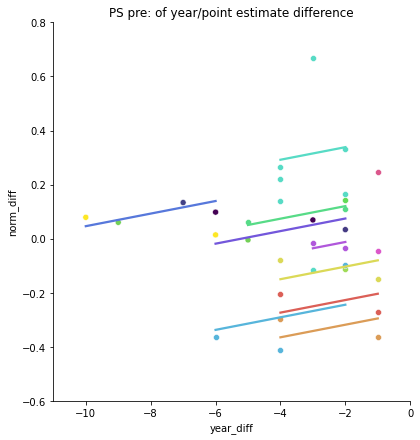

In [66]:
# repeated measures correlation
display(pg.rm_corr(data=no_zero_pairs[no_zero_pairs['ps_after'] == 0], x='year_diff', y='norm_diff', subject='study_id'))
pg.plot_rm_corr(data=no_zero_pairs[no_zero_pairs['ps_after'] == 0], x='year_diff', y='norm_diff', subject='study_id',
                kwargs_facetgrid=dict(
                    height=6
                ))
plt.title("PS pre: of year/point estimate difference")
plt.ylim(-0.6, 0.8)
plt.xlim(-11, 0)

,r,dof,pval,CI95%,power
rm_corr,-0.081763,34,0.635457,"[-0.4, 0.25]",0.075932


(0.0, 15.0)

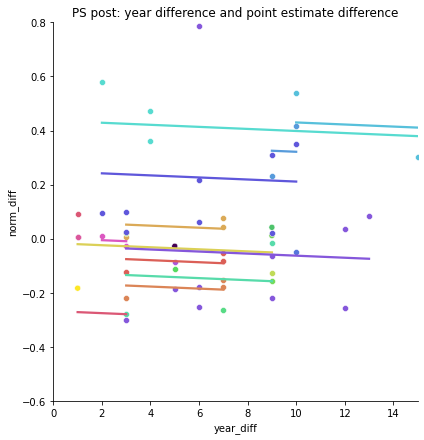

In [67]:
# repeated measures correlation
display(pg.rm_corr(data=no_zero_pairs[no_zero_pairs['ps_after'] == 1], x='year_diff', y='norm_diff', subject='study_id'))
pg.plot_rm_corr(data=no_zero_pairs[no_zero_pairs['ps_after'] == 1], x='year_diff', y='norm_diff', subject='study_id',
                kwargs_facetgrid=dict(
                    height=6
                ))
plt.title("PS post: year difference and point estimate difference")
plt.ylim(-0.6, 0.8)
plt.xlim(0, 15)

# Next steps

1. Can dig into the studies and pull out the studies with same year
2. Larger $n=127$ in main text, but some point estimates are aggregated

# Meeting notes

- RCT-RCT agreement is bad, and they overfit to the "best" one
- look at sample size as well